In [4]:

import pandas as pd
import numpy as np
# import torch
# import transformers
# import re
# import emoji
# import requests
# import matplotlib.pyplot as plt
# from collections import Counter
# from IPython.display import clear_output

In [5]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ7wqCI7NBcZX8pDfgQ9st7tAgV6HNub2rXXM7pB5-IZP1HVz1MiEe3E7i6pbwpbWl7XAKHPVSbIkN4/pub?gid=419680706&single=true&output=csv'
data_raw = pd.read_csv(url)

In [6]:
import re
import emoji

def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # hapus url
    text = re.sub(r'@[\w_]+', '', text)         # hapus mention
    text = re.sub(r'#\w+', '', text)            # hapus hashtag
    text = re.sub(r'RT[ ]?:?', '', text)         # hapus retweet/reply
    text = emoji.replace_emoji(text, replace='') # hapus emoji
    text = re.sub(r'[^\w\s]', '', text)        # hapus karakter non-alfanumerik
    text = re.sub(r'\s+', ' ', text)            # hapus spasi berlebih
    return text.strip().lower()

df = data_raw.copy()
df['cleaned'] = df['tweets_norm'].astype(str).apply(clean_tweet)
documents = df['cleaned'].tolist()
print(documents[:5])

['efisiensi terus uangnya dimasukkan ke danantara lalu efisiensinya dimana ndasmu', 'narasi ijazah jokowi in big 2025 literally ruu tni depan mata danantara depan mata bensin oplos depan mata', 'efisiensi yg kita kira diawal kan buat nambal buat alokasi dana ke proker utama tp ternyata kan cuma buat danantara jadi ya udah udah dipotong tekor jg masih', 'tung tang tung 10xmari ngutang lagi lewat danantaradsini ngutang disana ngutang tapi ga nyusu nyusu', 'demo danantara jg ampas krmn ga digubris wkwkwkw indonesia gelap aja malah dijadiin candaan pidato km ngetik gini ini sadar betul kah']


In [14]:
from transformers import BertTokenizerFast
from datasets import Dataset

# Membuat tokenizer baru dari data (WordPiece)
# Tokenizer akan di-train dari data, bukan load pretrained
from tokenizers import BertWordPieceTokenizer

import os
os.makedirs('Result/custombert', exist_ok=True)

with open('Result/custombert/tweets_corpus.txt', 'w', encoding='utf-8') as f:
    for line in documents:
        f.write(line + '\n')

# Train tokenizer
tokenizer = BertWordPieceTokenizer(lowercase=True)
tokenizer.train(files=['Result/custombert/tweets_corpus.txt'], vocab_size=3000, min_frequency=2, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
tokenizer.save_model('Result/custombert', 'custom_bert')

# Load ke transformers
hf_tokenizer = BertTokenizerFast(vocab_file='Result/custombert/custom_bert-vocab.txt')

dataset = Dataset.from_dict({'text': documents})

In [15]:
from transformers import BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch

def tokenize_function(examples):
    return hf_tokenizer(examples['text'], truncation=True, padding='max_length', max_length=64)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['text'])

data_collator = DataCollatorForLanguageModeling(tokenizer=hf_tokenizer, mlm=True, mlm_probability=0.15)

# Definisikan konfigurasi BERT dari awal
config = BertConfig(
    vocab_size=hf_tokenizer.vocab_size,
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=2,
    intermediate_size=256,
    max_position_embeddings=64,
)

model = BertForMaskedLM(config)


Map:   0%|          | 0/90563 [00:00<?, ? examples/s]

In [16]:
# Cek versi library penting
import torch
import transformers
import accelerate
print('torch:', torch.__version__)
print('transformers:', transformers.__version__)
print('accelerate:', accelerate.__version__)

torch: 2.6.0+cu126
transformers: 4.52.4
accelerate: 1.8.1


In [ ]:
# Training BERT dari awal (Masked Language Modeling)
training_args = TrainingArguments(
    output_dir="Result/custombert/bert-custom-out",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    save_steps=100,
    save_total_limit=1,
    logging_steps=20,
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

trainer.train()

In [18]:
# Mendapatkan embedding dokumen dari BERT hasil training
from torch.utils.data import DataLoader
from tqdm import tqdm

model.eval()
embeddings = []
loader = DataLoader(tokenized_dataset, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for batch in tqdm(loader):
        # Convert list of tensors to a single tensor
        def to_tensor(x):
            if torch.is_tensor(x):
                return x
            elif isinstance(x, list):
                return torch.stack(x)
            elif isinstance(x, tuple):
                return torch.stack(list(x))
            else:
                return x
        input_ids = to_tensor(batch['input_ids']).to(device)
        attention_mask = to_tensor(batch['attention_mask']).to(device)
        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        for emb in cls_emb:
            embeddings.append(emb)
import numpy as np
embeddings = np.array(embeddings)


100%|████████████████████████████████████████████████████████████████████████████████| 5661/5661 [00:41<00:00, 137.86it/s]



In [19]:
# Clustering embedding dokumen dan ekstraksi kata kunci
# Pastikan hanya satu embedding per dokumen (batch)
# embeddings seharusnya (n_docs, hidden_dim)

# Jika embeddings.shape[0] > len(df), kemungkinan hasil vstack dari batch, perlu reshape
# Ambil hanya baris pertama dari setiap batch_size (yaitu [0, batch_size, 2*batch_size, ...])
batch_size = 16
# Pastikan jumlah embeddings sama dengan jumlah dokumen
if embeddings.shape[0] > len(df):
    n_docs = len(df)
    embeddings = embeddings[:n_docs]  # ambil hanya sebanyak jumlah dokumenumen

print("embeddings shape:", embeddings.shape)
print("df shape:", df.shape)

from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)
print("labels shape:", labels.shape)

def get_top_keywords(cluster_docs, n=10):
    from collections import Counter
    all_words = ' '.join(cluster_docs).split()
    return [w for w, _ in Counter(all_words).most_common(n)]

if len(labels) == len(df):
    df['topic'] = labels
    for i in range(n_clusters):
        cluster_docs = df[df['topic'] == i]['cleaned'].tolist()
        print(f"Topik {i}: ", get_top_keywords(cluster_docs))
else:
    print(f"Error: labels length ({len(labels)}) does not match df length ({len(df)})")

embeddings shape: (90563, 128)
df shape: (90563, 11)
labels shape: (90563,)
Topik 0:  ['danantara', 'dan', 'danantaraporosinvestasi', 'yang', 'ekonomi', 'di', 'investasi', 'indonesia', 'dengan', 'untuk']
Topik 1:  ['danantara', 'dan', 'ekonomi', 'yang', 'danantaraporosinvestasi', 'danantarabangunnegeri', 'di', 'indonesia', 'investasi', 'dengan']
labels shape: (90563,)
Topik 0:  ['danantara', 'dan', 'danantaraporosinvestasi', 'yang', 'ekonomi', 'di', 'investasi', 'indonesia', 'dengan', 'untuk']
Topik 1:  ['danantara', 'dan', 'ekonomi', 'yang', 'danantaraporosinvestasi', 'danantarabangunnegeri', 'di', 'indonesia', 'investasi', 'dengan']
Topik 2:  ['danantara', 'dan', 'ekonomi', 'yang', 'di', 'danantaraporosinvestasi', 'danantarabangunnegeri', 'indonesia', 'dengan', 'investasi']
Topik 3:  ['danantara', 'dan', 'ekonomi', 'yang', 'danantaraporosinvestasi', 'danantarabangunnegeri', 'di', 'indonesia', 'investasi', 'dengan']
Topik 4:  ['danantara', 'dan', 'ekonomi', 'yang', 'danantarabangunneg

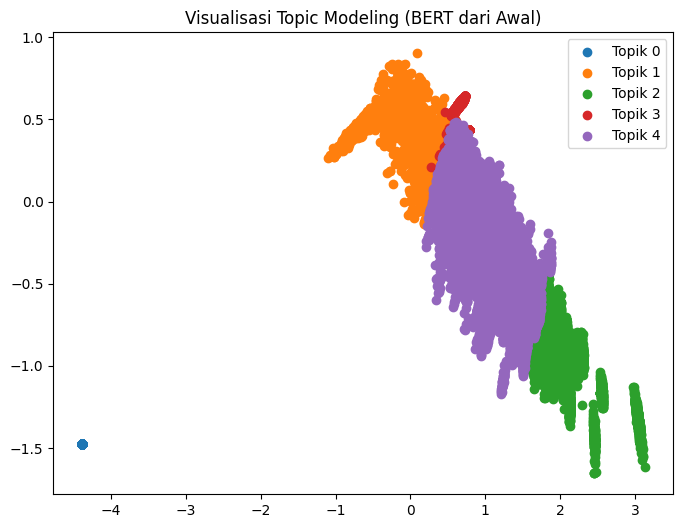

Hasil topic modeling disimpan ke Result/custombert/topic/topic_modeling_custombert.csv
Kata kunci tiap topik disimpan ke Result/custombert/topic/topic_keywords_custombert.csv
Kata kunci tiap topik disimpan ke Result/custombert/topic/topic_keywords_custombert.csv


In [20]:
# Visualisasi hasil topic modeling dan simpan ke CSV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

if 'topic' in df.columns:
    pca = PCA(n_components=2)
    emb2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    for i in range(n_clusters):
        idx = df['topic'] == i
        plt.scatter(emb2d[idx,0], emb2d[idx,1], label=f"Topik {i}")
    plt.legend()
    plt.title("Visualisasi Topic Modeling (BERT dari Awal)")
    plt.show()

    import os
    # Simpan hasil topic modeling dan keywords per topik
    os.makedirs('Result/custombert/topic', exist_ok=True)
    df.to_csv('Result/custombert/topic/topic_modeling_custombert.csv', index=False)
    print('Hasil topic modeling disimpan ke Result/custombert/topic/topic_modeling_custombert.csv')
    # Simpan keywords per topik
    topic_keywords = []
    for i in range(n_clusters):
        cluster_docs = df[df['topic'] == i]['cleaned'].tolist()
        keywords = get_top_keywords(cluster_docs)
        topic_keywords.append({'topic': i, 'keywords': ', '.join(keywords)})
    import pandas as pd
    pd.DataFrame(topic_keywords).to_csv('Result/custombert/topic/topic_keywords_custombert.csv', index=False)
    print('Kata kunci tiap topik disimpan ke Result/custombert/topic/topic_keywords_custombert.csv')
else:
    print("Kolom 'topic' tidak ditemukan di df. Pastikan proses clustering berhasil dan jumlah label sesuai jumlah data.")